In [38]:
#import pertinent libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import random
from tensorflow import keras
import time

In [39]:
#matplotlib plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams as rc
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
lw1 = 3.6
lw2 = 2.4
lw3 = 2.4
ft1 = 30
ft2 = 30
lg = 26
tl1 = 12
tl2 = 8
rc.update({'figure.figsize': (12,9)})
rc.update({'axes.labelsize': ft1})
rc.update({'axes.titlesize': ft1})
rc.update({'axes.linewidth': lw2})
rc.update({'lines.linewidth': lw1})
rc.update({'axes.formatter.limits': (-4,4)})
rc.update({'lines.markersize': 20.})
rc.update({'lines.markeredgewidth': lw1})
rc.update({'markers.fillstyle': 'none'})
rc.update({'xtick.labelsize': ft2})
rc.update({'ytick.labelsize': ft2})
rc.update({'xtick.direction': 'out'})
rc.update({'ytick.direction': 'out'})
rc.update({'xtick.major.size': tl1})
rc.update({'ytick.major.size': tl1})
rc.update({'xtick.minor.size': tl2})
rc.update({'ytick.minor.size': tl2})
rc.update({'xtick.minor.width': lw3})
rc.update({'xtick.major.width': lw3})
rc.update({'xtick.minor.width': lw3})
rc.update({'ytick.major.width': lw3})
rc.update({'ytick.minor.width': lw3})
rc.update({'xtick.major.pad': '8'})
rc.update({'ytick.major.pad': '10'})
rc.update({'xtick.top': False})
rc.update({'ytick.right': False})
rc.update({'legend.fontsize': lg})
rc.update({'legend.numpoints': 1})
rc.update({'legend.frameon': False})
rc.update({'font.family':'STIXGeneral','mathtext.fontset':'stix'})

cols = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd',
        u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

In [40]:
#helper functions
sigmoid = lambda x : 1 / (1+np.exp(-x))
def mc(m1, m2):
    return ((m1 * m2) ** 0.6) / ( (m1 + m2)**0.2 )

#pertinent to the data normalization that we used
mc_max = mc(50, 50)
e_max = 0.3

#encapsulating class to "compactify" code
class Pipeline:
    def __init__(self, fs, duration, split_dur, noise_amp, signal, 
                 model_paths, norm_consts, mc, e_hist):
        assert(duration > len(signal))
        self.fs = fs
        self.timebase = np.arange(0, duration/fs, 1/fs)
        self.duration = duration
        self.noise = np.random.normal(0, noise_amp, duration)
        
        self.mc = mc
        self.e_hist = e_hist
        
        self.create_strain_splits(signal, split_dur)
        self.extend_realvals(signal)
        self.biclass_eval(model_paths[0], norm_consts[0])
        self.parame_eval(model_paths[1], norm_consts[1])

        self.make_plots(signal, split_dur)

    def make_plots(self, signal, split_dur):
        #function to create all of the plots shown in the paper
        
        #strain plot
        fs = self.fs
        param_buffer = len(signal) * 0.0016
        pb = param_buffer
        fig, ax = plt.subplots(figsize = (15, 11))
        ax.set(xlabel = "Time, Hours", ylabel =r"Strain", 
               title = r"Pipeline Strain")
       
        timebase_hours = self.timebase / 3600
        ax.plot(timebase_hours, self.strain, label = "pipeline strain")
        ts_strain = np.linspace(self.insert_location/self.fs, (self.insert_location+len(signal))/self.fs, len(signal))
        ts_strain_hrs = ts_strain /3600
        ax.plot(ts_strain_hrs, signal, label = "raw signal")
        ax.legend()   
        plt.show()
        
        #binary classifier evalulation plot
        fig, ax = plt.subplots(figsize = (15, 11))
        ax.set(xlabel = "Time, hours", ylabel =r"Classifier evaluation, $\mathcal{P}$(signal)", 
               title = "Binary classifier evaluation")
        ts_biclass = np.linspace(0, self.duration/self.fs, len(self.biclass_predics))
        ts_biclass_hours = ts_biclass/3600
        ax.plot(ts_biclass_hours, self.biclass_predics)
        plt.show()
        
        #chirp mass prediction plot
        fig, ax = plt.subplots(figsize = (15, 11))
        ax.set(xlabel = "Time, hours", ylabel =r"Predicted $\mathcal{M}_c$, $M_{\odot}$", 
               title = r"$\mathcal{M}_c$ Predictions", 
               xlim = ((self.insert_location/fs-pb)/3600, (self.insert_location/fs + len(signal)/fs+pb)/3600))

        ts_parame = ts_biclass
        ts_parame_hours = ts_parame / 3600
        ax.plot(ts_parame_hours, self.extended_ppredics[:, 0], label = r"predicted $\mathcal{M}_c$")
        ax.plot(timebase_hours, self.mc_extend, 
               label = r"true $\mathcal{M}_c$", c="r")

        ax.legend()
        plt.show()
            
        #eccentricity prediction plot
        fig, ax = plt.subplots(figsize = (15, 11))
        ax.set(xlabel = "Time, hours", ylabel =r"Predicted $e$", 
               title = r"$e$ Predictions", 
               xlim = ((self.insert_location/fs-pb)/3600, (self.insert_location/fs + len(signal)/fs+pb)/3600))#, ylim = (24, 28))
        ax.plot(ts_parame_hours, self.extended_ppredics[:, 1], label = r"predicted $e$")
        ax.plot(timebase_hours, self.e_extend, 
               label = r"true $e$", c="r")
        ax.legend()
        plt.show()
        
    def create_strain_splits(self, signal, split_dur):
        self.insert_location = int(np.random.uniform(0, self.duration-1.2*len(signal)))
        self.strain = np.copy(self.noise)
        self.strain[self.insert_location:self.insert_location+len(signal)] += signal
        maxlen = int((self.duration // split_dur) * split_dur)
        self.splits = np.reshape(self.strain[:maxlen], (maxlen//split_dur, split_dur))
        self.psds = np.log10(np.array(sig.welch(self.splits, fs=self.fs)[1])[:, :20])
        
    def biclass_eval(self, path, const):
        biclass_model = keras.models.load_model(path)
        self.biclass_predics = biclass_model.predict(self.psds - const)
        
    def parame_eval(self, path, const):
        #doing full evaluation here
        parame_model = keras.models.load_model(path)
        chosen_psds = self.psds
        start = -1
        end = -1
        bar = 0.5
        for i, bi_eval in enumerate(self.biclass_predics):
            if bi_eval > bar and start == -1:
                start = i
            if bi_eval > bar:
                end = i
                
        self.s_start = start
        self.s_end = end
        chosen_psds = self.psds[start:end]
        self.parame_predics = np.array(parame_model.predict(chosen_psds - const))
        self.extended_ppredics = np.vstack([np.zeros((start, 2)), self.parame_predics, np.zeros((len(self.psds)-end, 2))])
        self.extended_ppredics[:, 0] *= mc_max
        self.extended_ppredics[:, 1] *= e_max
           
    def extend_realvals(self, signal):
        #make zero filled versions of the real parameters so that they can be plotted more nicely
        il = self.insert_location
        front = np.zeros((il, 1))
        back = np.zeros((len(self.strain) - len(signal) - il, 1))
        
        mc_ex = self.mc * np.ones((len(signal), 1))
        self.mc_extend = np.vstack([front, mc_ex, back])
        self.e_hist = np.expand_dims(self.e_hist, axis = 1)
        self.e_extend = np.vstack([front, self.e_hist, back])
        

In [45]:
#normalization constants from the training of the neural network, binary classifier first
norm_consts = [-45.57965415798402, -45.409285707159476]
model_base_path = "../neural_network_training/" #configure accordingly
model_paths = [
    model_base_path + "binary_classification_network.h5",
    model_base_path + "parameter_estimation_network.h5"]
#path for saved waveforms
waveform_path = "./example_waveforms/" #configure accordingly

def load_random_waveform(waveform_path):
    n_opts = len(os.listdir(waveform_path))//2
    choice = int(np.random.uniform(0, n_opts))
    signal_path = os.listdir(waveform_path)[2*choice]
    ehist_path = os.listdir(waveform_path)[2*choice+1]
    
    #extract chirp mass from the name of data file
    mc_val = (float(signal_path.split("_")[1][:-6]))
    
    signal = np.load(waveform_path + signal_path)
    e_hist = np.load(waveform_path + ehist_path)
    
    return mc_val, signal, e_hist

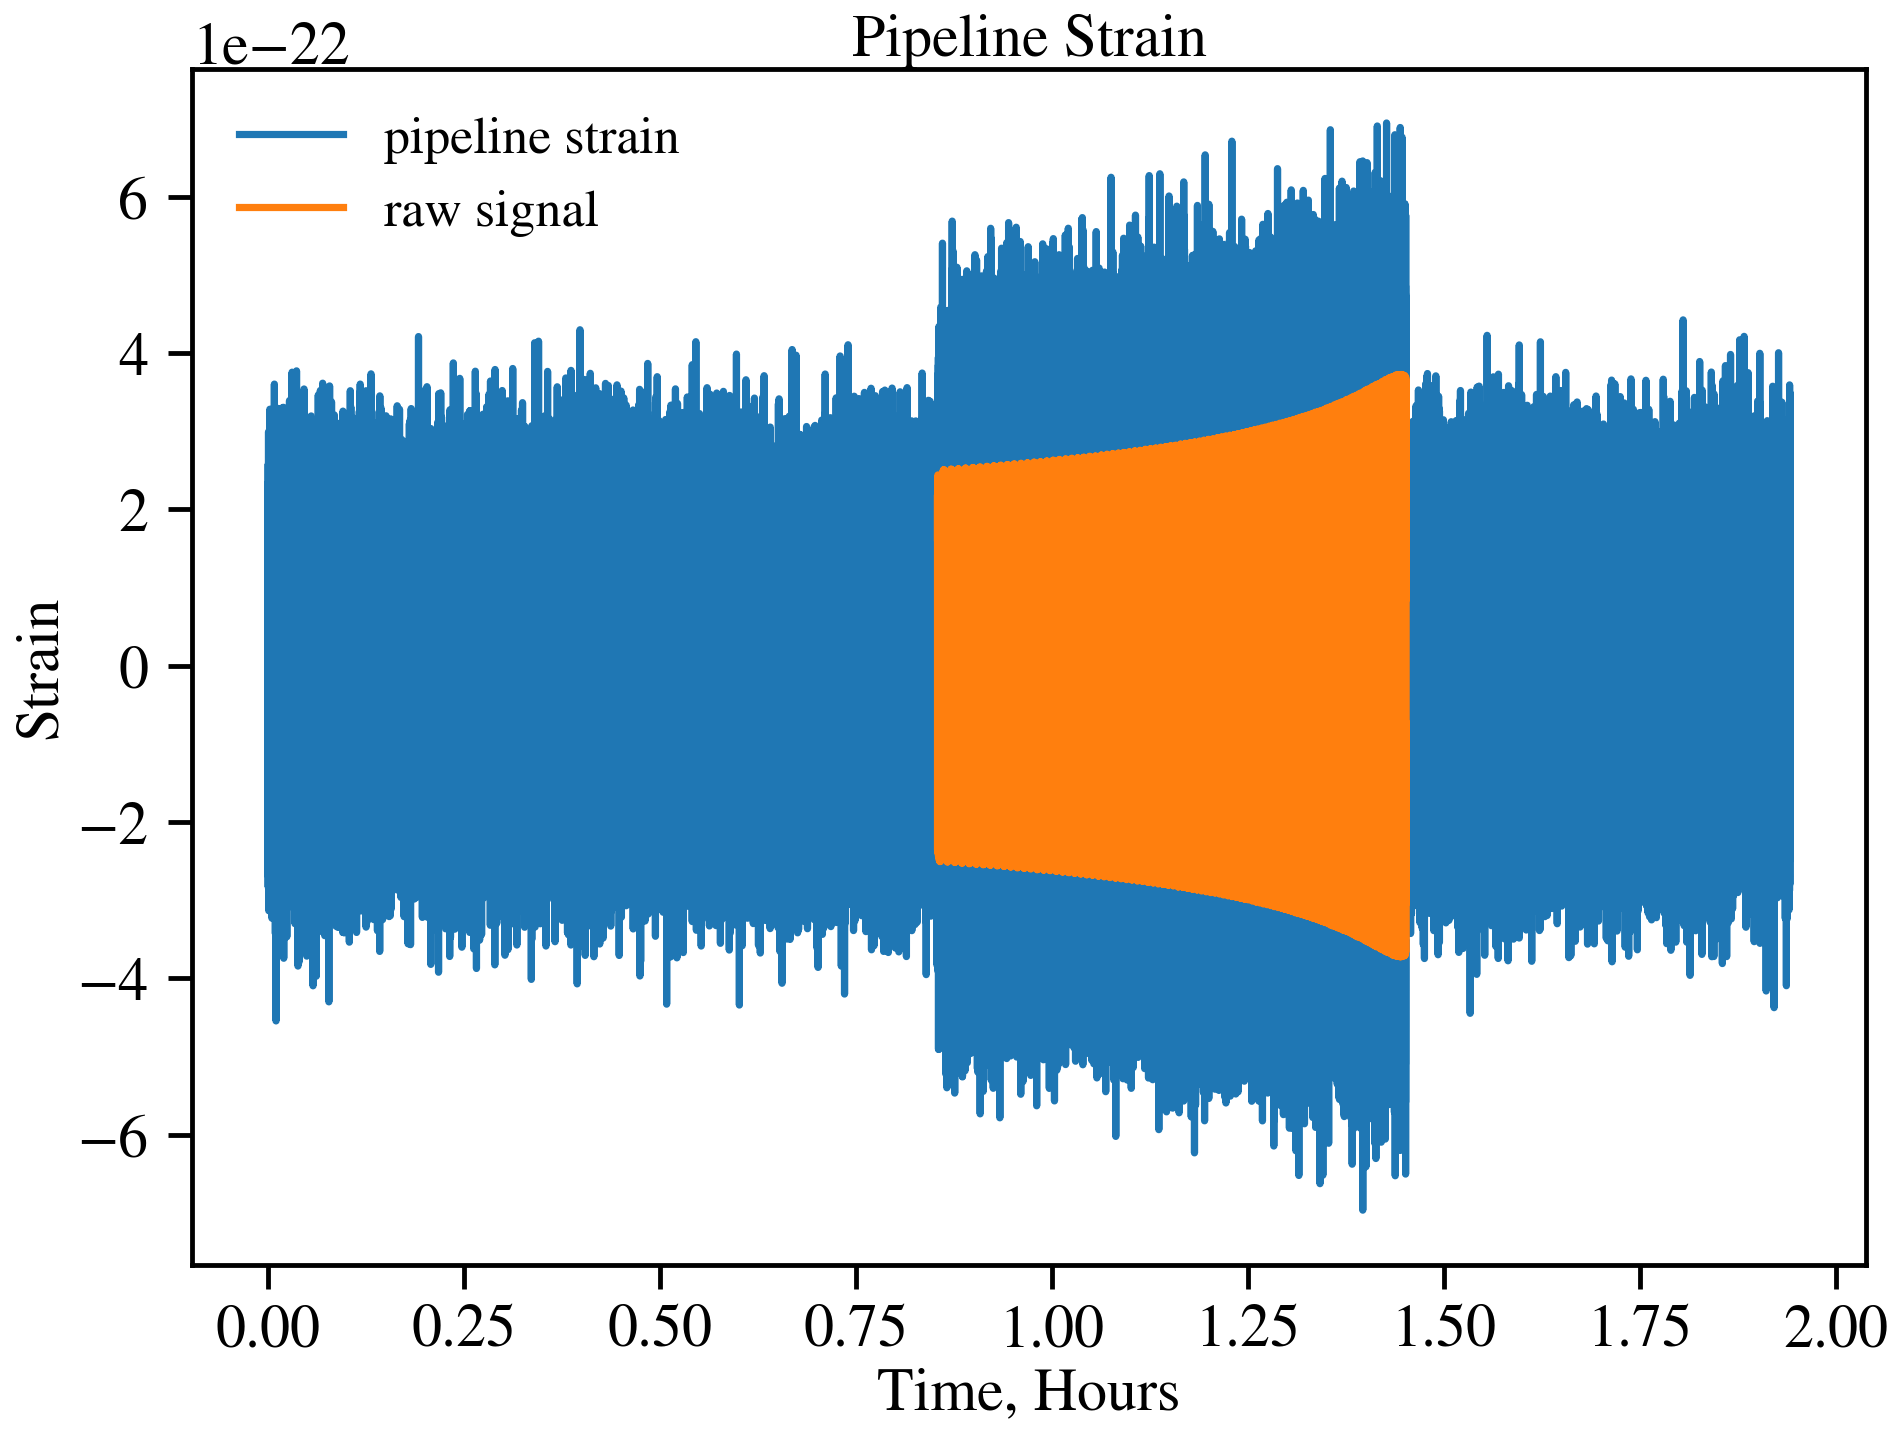

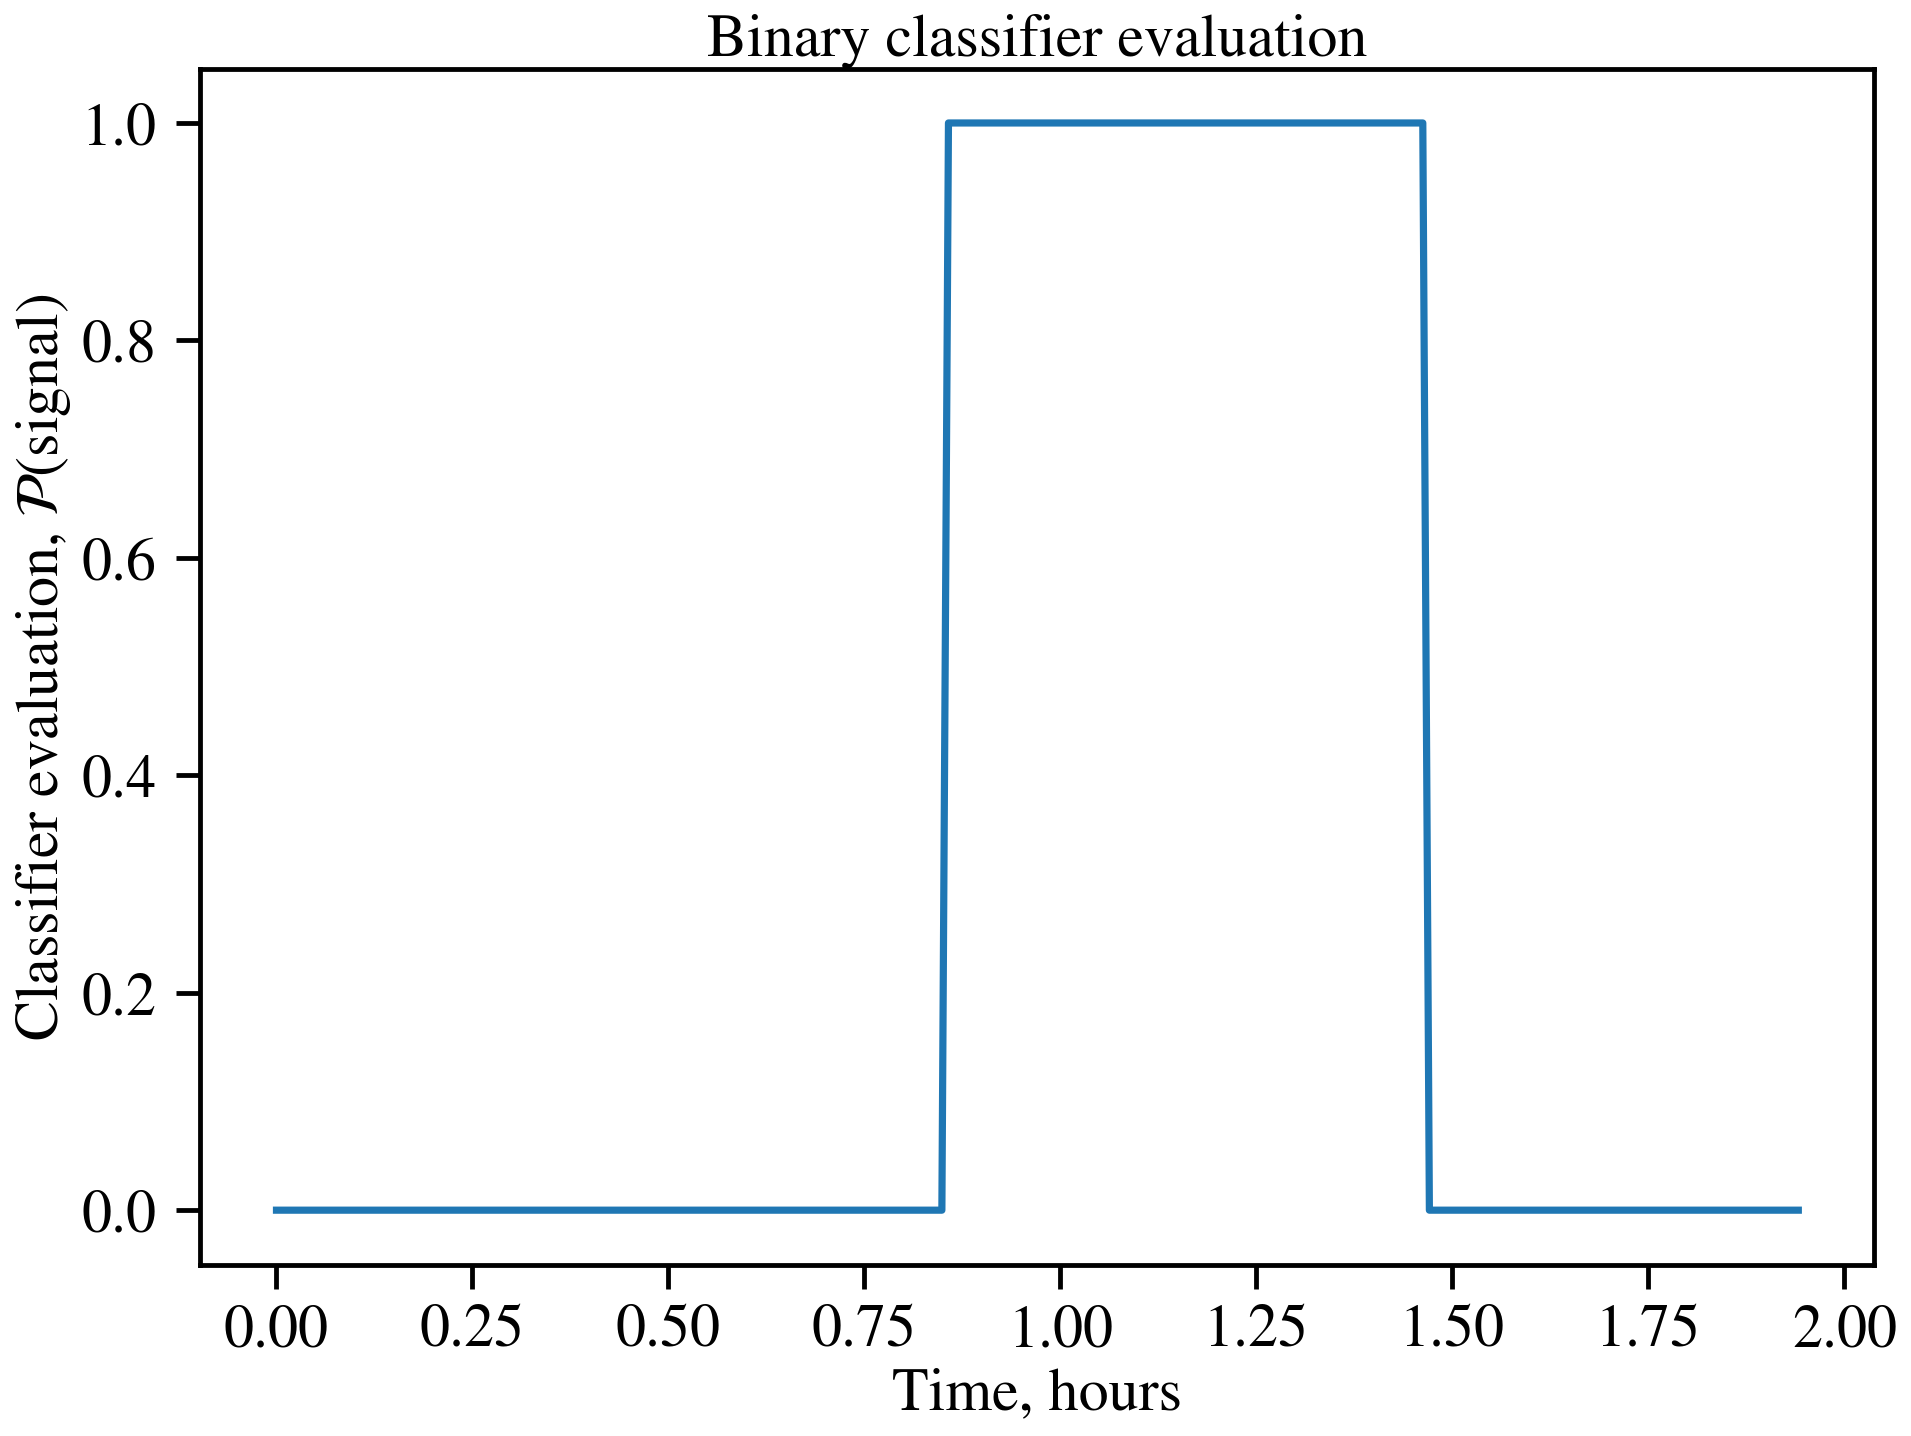

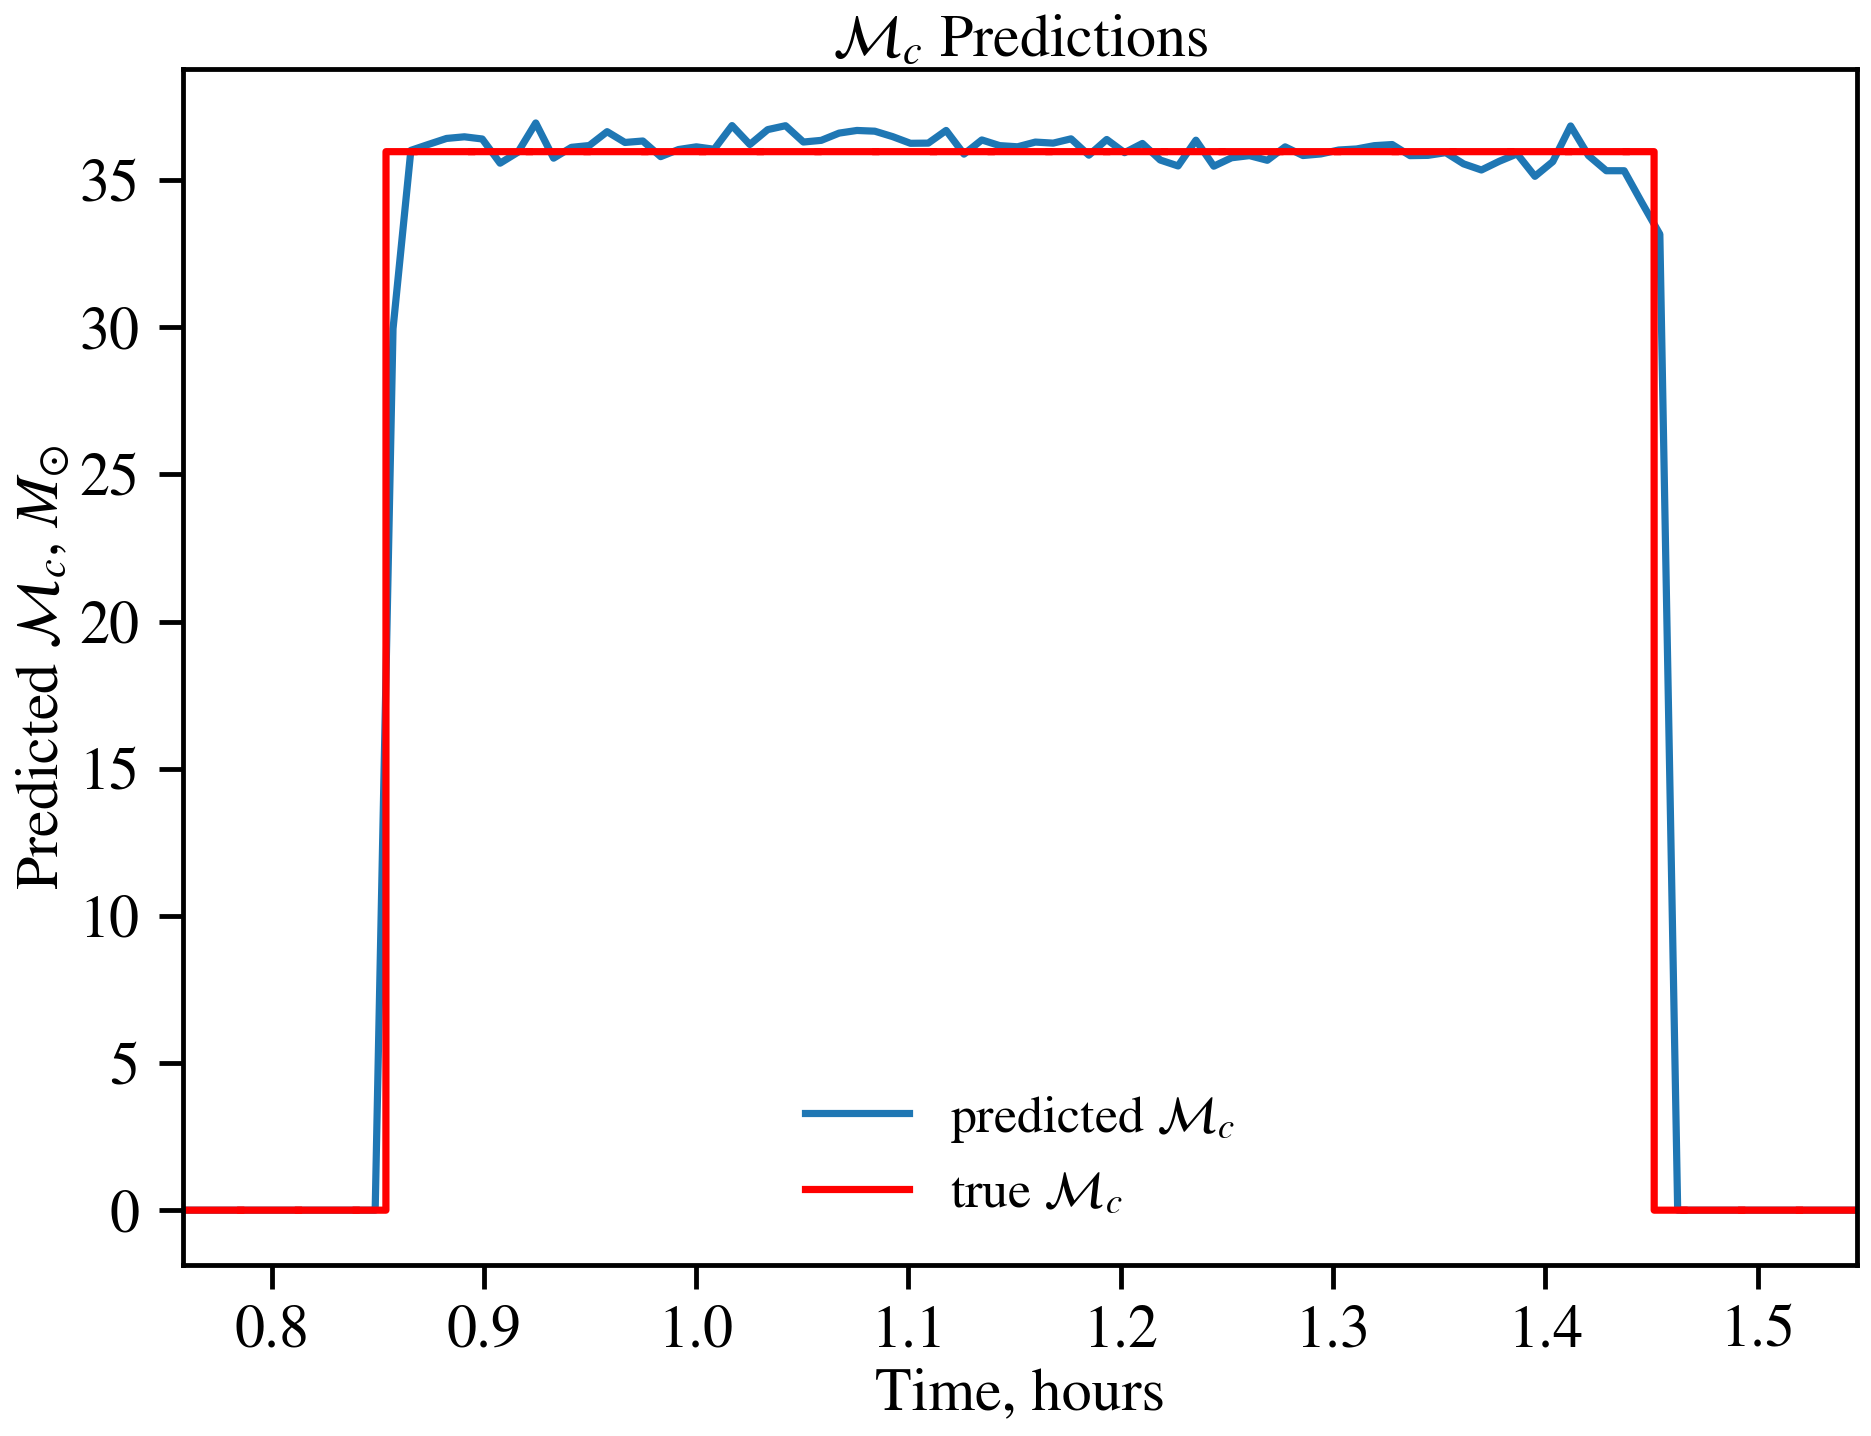

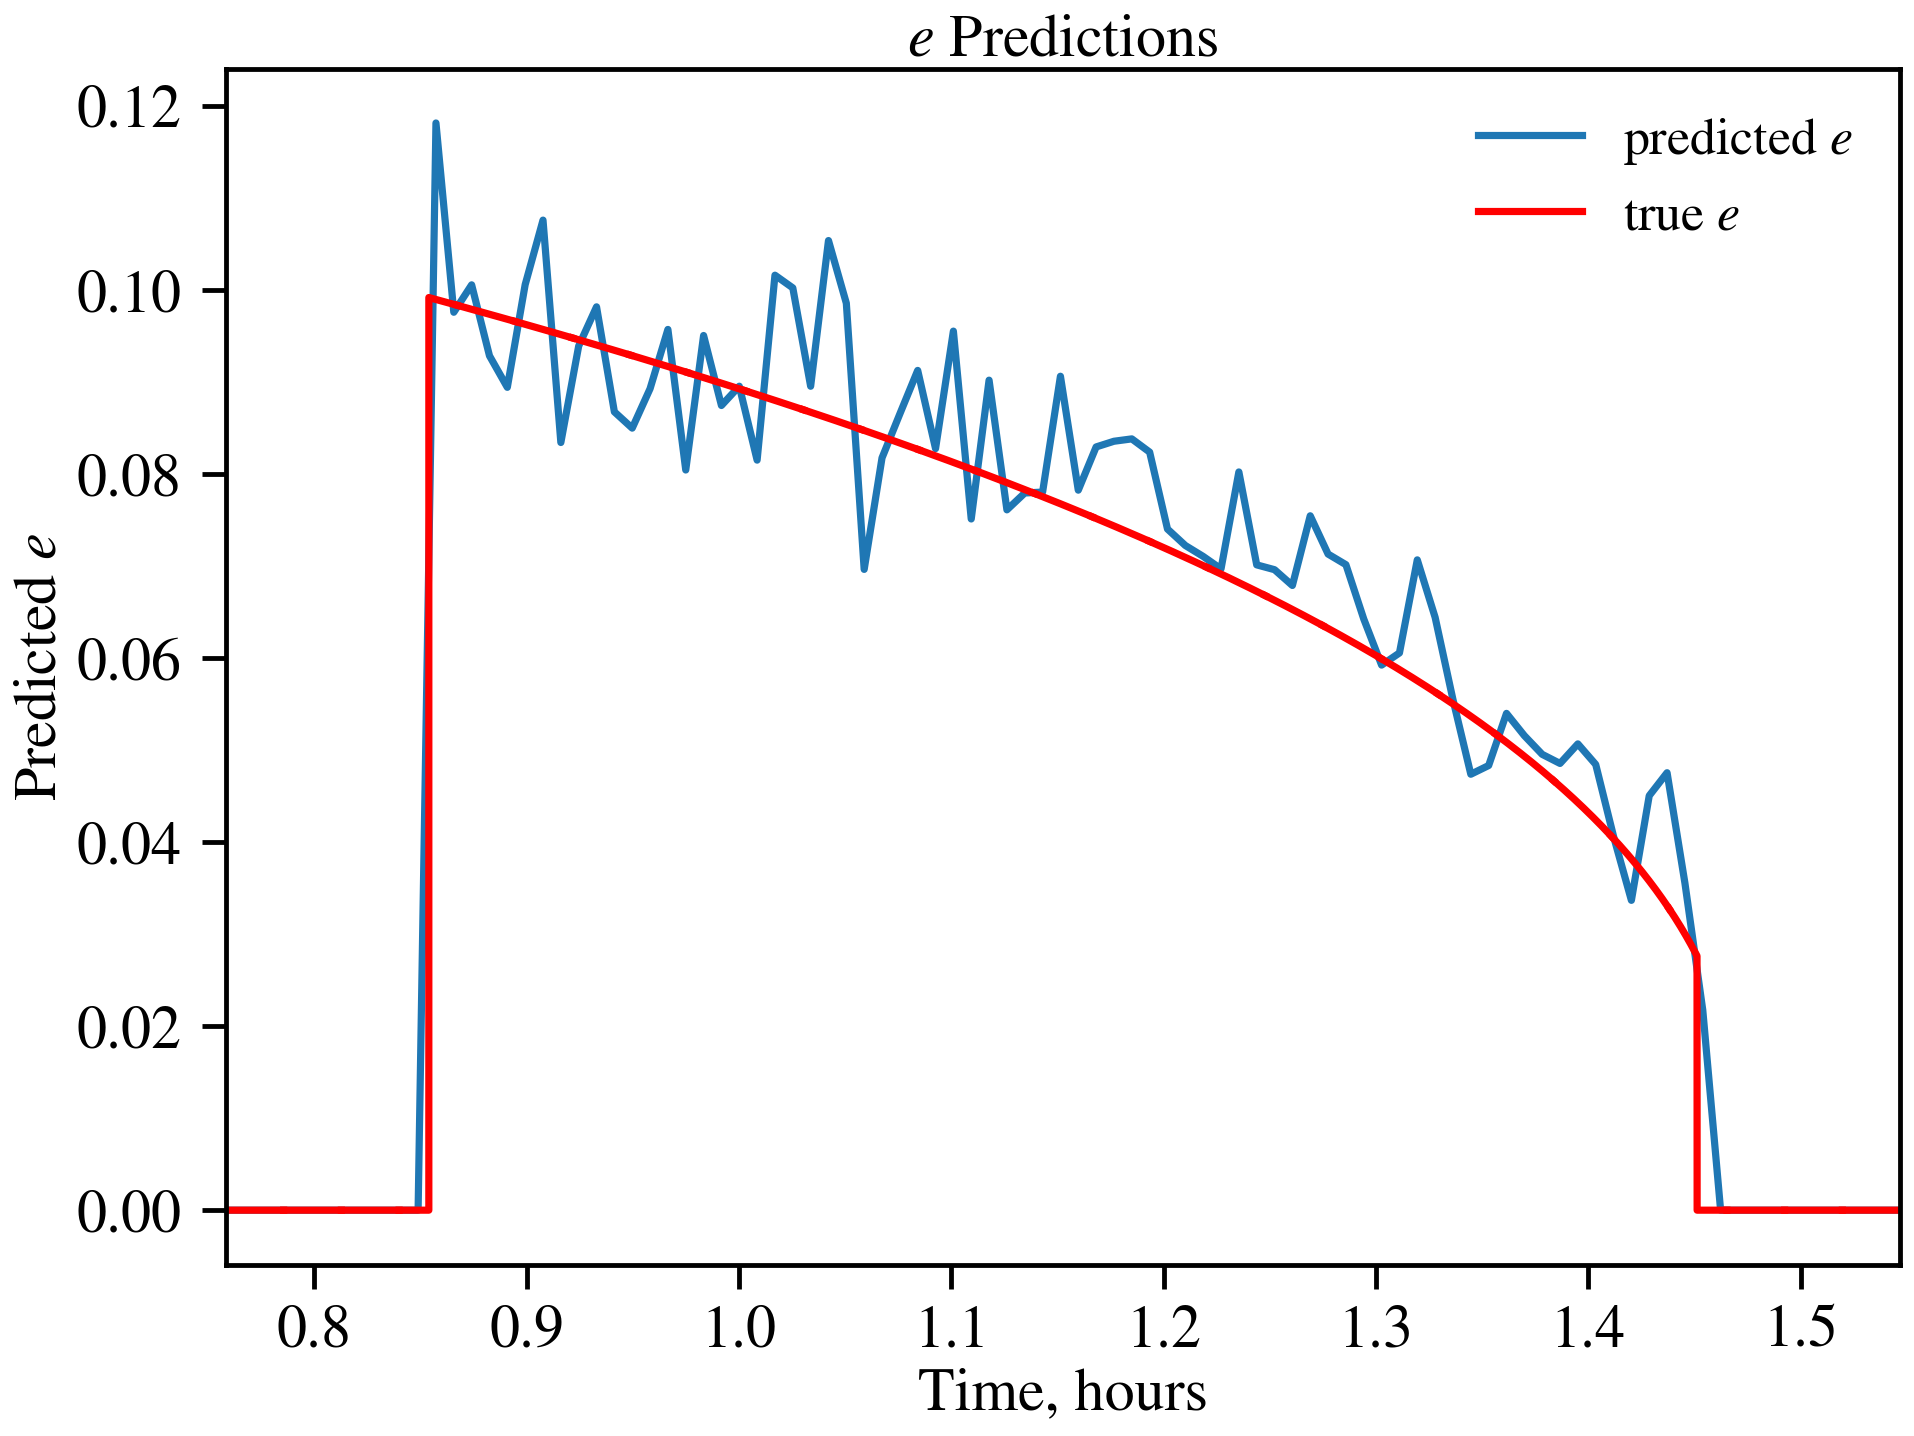

In [47]:
mc_val, signal, e_hist = load_random_waveform(waveform_path)
fs=100 #Hz
split_len=30 #seconds
noise_amp = 1e-22
test = Pipeline(fs, int(3.25*len(signal)), split_len*fs, noise_amp, signal, model_paths, norm_consts, mc_val, e_hist)